# Wave equation to frequency domain

This notebook is based on the Devito tutorial:

[17 - On-the-fly discrete Fourier transform | Devito](https://www.devitoproject.org/examples/seismic/tutorials/17_fourier_mode.html)

### On-the-fly Fourier Transform

The discrete Fourier transform (DFT) is defined as:

$$ X_k = \sum_{n=0}^{N-1} x_n e^{-i 2 \pi k n / N} $$

where: - $X_k$ is the DFT of the sequence $x_n$ - $N$ is the number of samples - $k$ is the frequency index - $n$ is the time index

the DFT can be used to compute the frequency components of the wavefield as it propagates through the subsurface.

The key idea is to update the Fourier modes at each time step using the current wavefield values:

$$ F_k(t+\Delta t) = F_k(t) + u(t) e^{-i \omega_k t \Delta t} $$

where: - $F_k(t)$ is the Fourier mode at frequency $\omega_k$ and time $t$ - $u(t)$ is the wavefield at time $t$ - $\Delta t$ is the time step

In [1]:
%matplotlib ipympl

In [2]:
from devito import *
from examples.seismic import demo_model, AcquisitionGeometry, plot_velocity, TimeAxis, RickerSource
import matplotlib.pyplot as plt
import scipy as sp
import matplotlib.gridspec as gridspec

#### 1. Model and Aquisition Geometry

Operator `initdamp` ran in 0.01 s


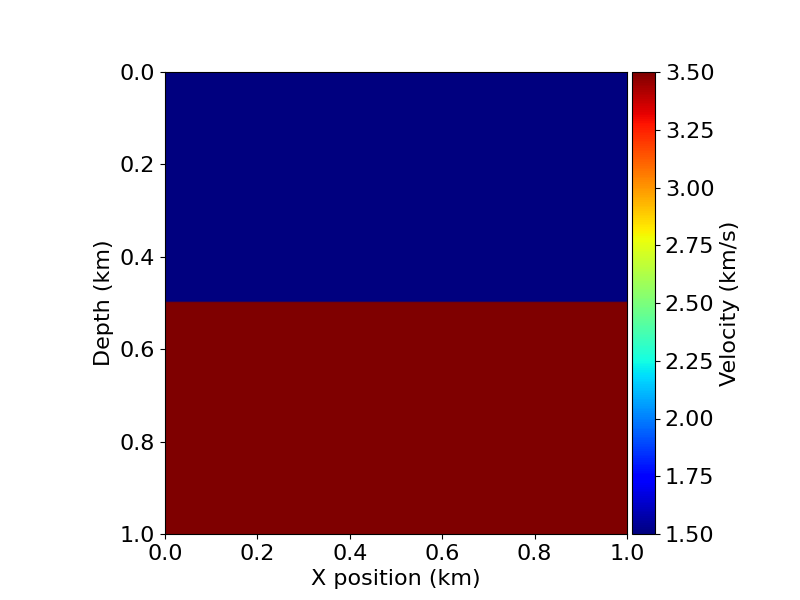

In [3]:
model = demo_model('layers-isotropic', vp=3.0, origin=(0., 0.), shape=(201, 201), spacing=(5., 5.), nbl=150, nlayers=2)
plot_velocity(model)

In [4]:
# Define acquisition geometry: source

# First, position source centrally in all dimensions, then set depth
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.array(model.domain_size) * .5
src_coordinates[0, -1] = 20.  # Depth is 20m

# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
nreceivers = 201
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 1] = 30.

# Geometry
t0 = 0.
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt
geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=.010, src_type='Ricker', t0w=100)

#### 2. Source Time Analysis

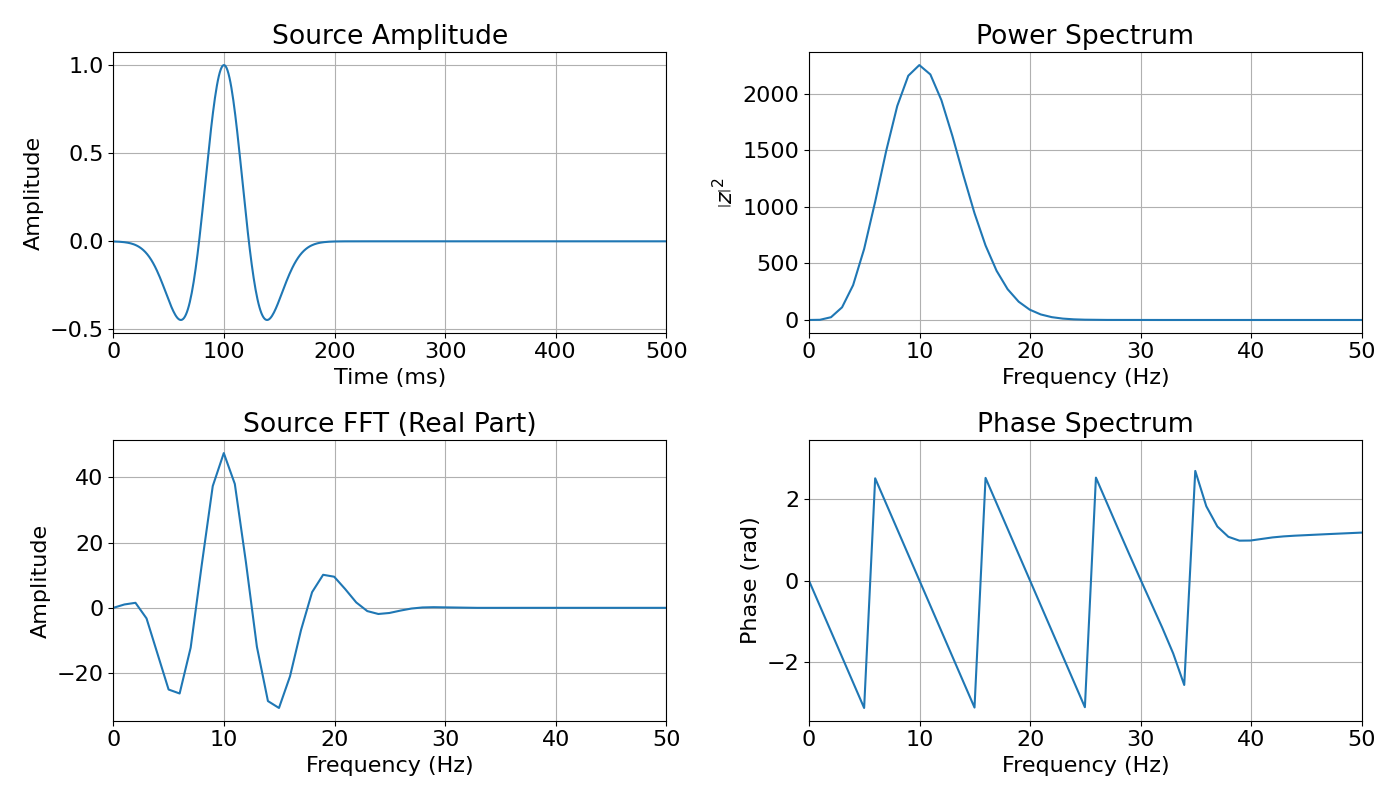

In [5]:
#%matplotlib inline

source_amplitude = geometry.src.data
source_t = geometry.src.time_values

dt_source = np.diff(source_t).mean()
source_FFT = np.fft.fft(source_amplitude, axis=0)
source_freq_vector = np.fft.fftfreq(source_t.shape[-1], d=dt_source)
source_FFT_real = np.fft.rfft(source_amplitude, axis=0)
source_freq_vector_real = np.fft.rfftfreq(source_t.shape[-1], d=dt_source)

fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])

ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(source_t, source_amplitude)
ax0.set_title("Source Amplitude")
ax0.set_xlim(0, 500)
ax0.set_xlabel("Time (ms)")
ax0.set_ylabel("Amplitude")
ax0.grid()

ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(source_freq_vector_real*1000, np.real(source_FFT_real))
ax1.set_title("Source FFT (Real Part)")
ax1.set_xlim(0, 50)
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Amplitude")
ax1.grid()

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(source_freq_vector_real*1000, abs(source_FFT_real)**2)
ax2.set_title("Power Spectrum")
ax2.set_ylabel(r"$\left|z\right|^2$")
ax2.set_xlabel("Frequency (Hz)")
ax2.set_xlim(0, 50)
ax2.grid()

ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(source_freq_vector_real*1000, np.angle(source_FFT_real))
ax3.set_title("Phase Spectrum")
ax3.set_xlim(0, 50)
ax3.set_xlabel("Frequency (Hz)")
ax3.set_ylabel("Phase (rad)")
ax3.grid()

fig.tight_layout()
plt.show()

#### 3. Solution

In [6]:
# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2, save=geometry.nt)

# We can now write the PDE
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

# Stencil update
stencil = Eq(u.forward, solve(pde, u.forward))
stencil

Eq(u(time + dt, x, y), (-(-2.0*u(time, x, y)/dt**2 + u(time - dt, x, y)/dt**2)/vp(x, y)**2 + Derivative(u(time, x, y), (x, 2)) + Derivative(u(time, x, y), (y, 2)) + damp(x, y)*u(time, x, y)/dt)/(damp(x, y)/dt + 1/(dt**2*vp(x, y)**2)))

In [7]:
nfreq = 40
f = Dimension(name='f')

frequencies = Function(name='frequencies', dimensions=(f,), shape=(nfreq,), dtype=np.float32)
frequencies.data[:] = np.linspace(0.000, 0.02, num=nfreq)

freq_modes = Function(name='freq_modes', grid=model.grid, space_order=0, dtype=np.complex64,
                      dimensions=(f, *model.grid.dimensions), shape=(nfreq, *model.grid.shape))

omega = 2 * np.pi * frequencies
basis = exp(-1j * omega * model.grid.time_dim * model.grid.time_dim.spacing)
dfts = [Inc(freq_modes, basis * u)]

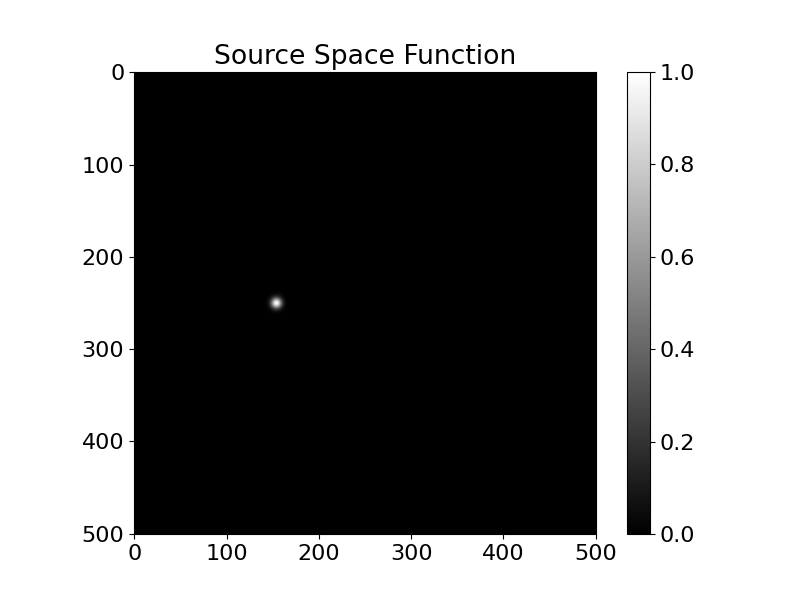

Eq(u(time + dt, x, y), 0.765275*vp(x, y)**2*src_space(x, y)*src(time, p_src) + u(time + dt, x, y))

In [76]:
# Define the receiver read function
# Create interpolation expression for receivers
rec = geometry.rec
rec_term = rec.interpolate(expr=u.forward)

if False:
    # Define the source injection
    src = geometry.src
    src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
    op = Operator([stencil] + src_term + rec_term + dfts, subs=model.spacing_map)

else:
    # Define the source space function
    src_space = Function(name='src_space', grid=model.grid)

    x0 = geometry.src_positions[0][1]+model.nbl*model.spacing[1]
    z0 = geometry.src_positions[0][0]+model.nbl*model.spacing[0]

    sigma = 20

    X, Z = np.meshgrid(np.linspace(0, model.grid.extent[0], model.grid.shape[0]),
                        np.linspace(0, model.grid.extent[1], model.grid.shape[1]))

    src_space.data[:] = np.exp(-((X - x0)**2 + (Z - z0)**2) / (2 * sigma**2))

    plt.figure()
    plt.imshow(src_space.data, cmap='gray')
    plt.colorbar()
    plt.title('Source Space Function')
    plt.show()

    src_expr = src_space*geometry.src * dt**2 / model.m
    eq_src = Eq(u.forward, u.forward + src_expr)
    display(eq_src)

    op = Operator([stencil, eq_src] + rec_term + dfts, subs=model.spacing_map)

In [9]:
u.data.fill(0)
op(dt=model.critical_dt)

Operator `Kernel` ran in 4.26 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.15288700000000105, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0016819999999999884, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.000193, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section3', rank=None),
                     PerfEntry(time=4.096899, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

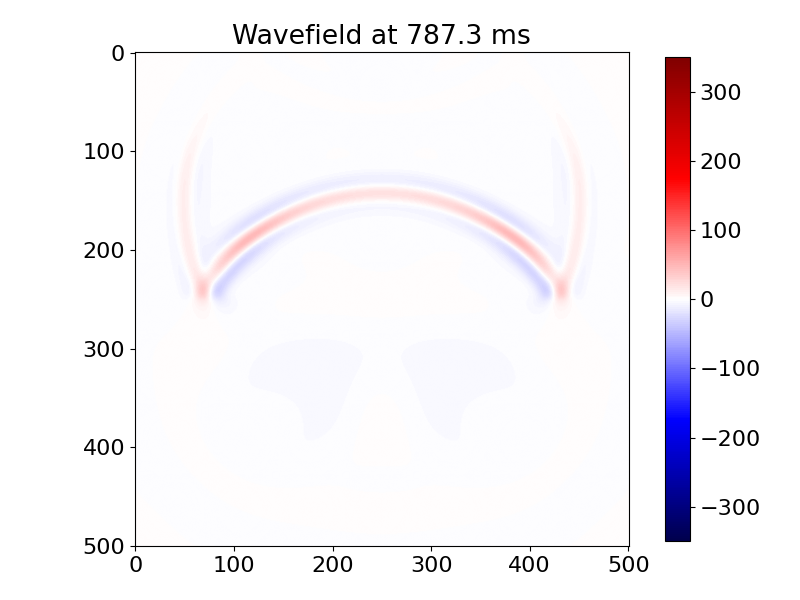

In [10]:
time_instant = 900
plt.figure()
im1 = plt.imshow(u.data[time_instant].T, cmap='seismic', vmin=-350, vmax=350)
plt.colorbar(im1, shrink=0.98)
plt.title(f'Wavefield at {geometry.time_axis.time_values[time_instant]:.1f} ms')
plt.tight_layout()

In [11]:
idx_domain_ROI = (slice(None), slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl))

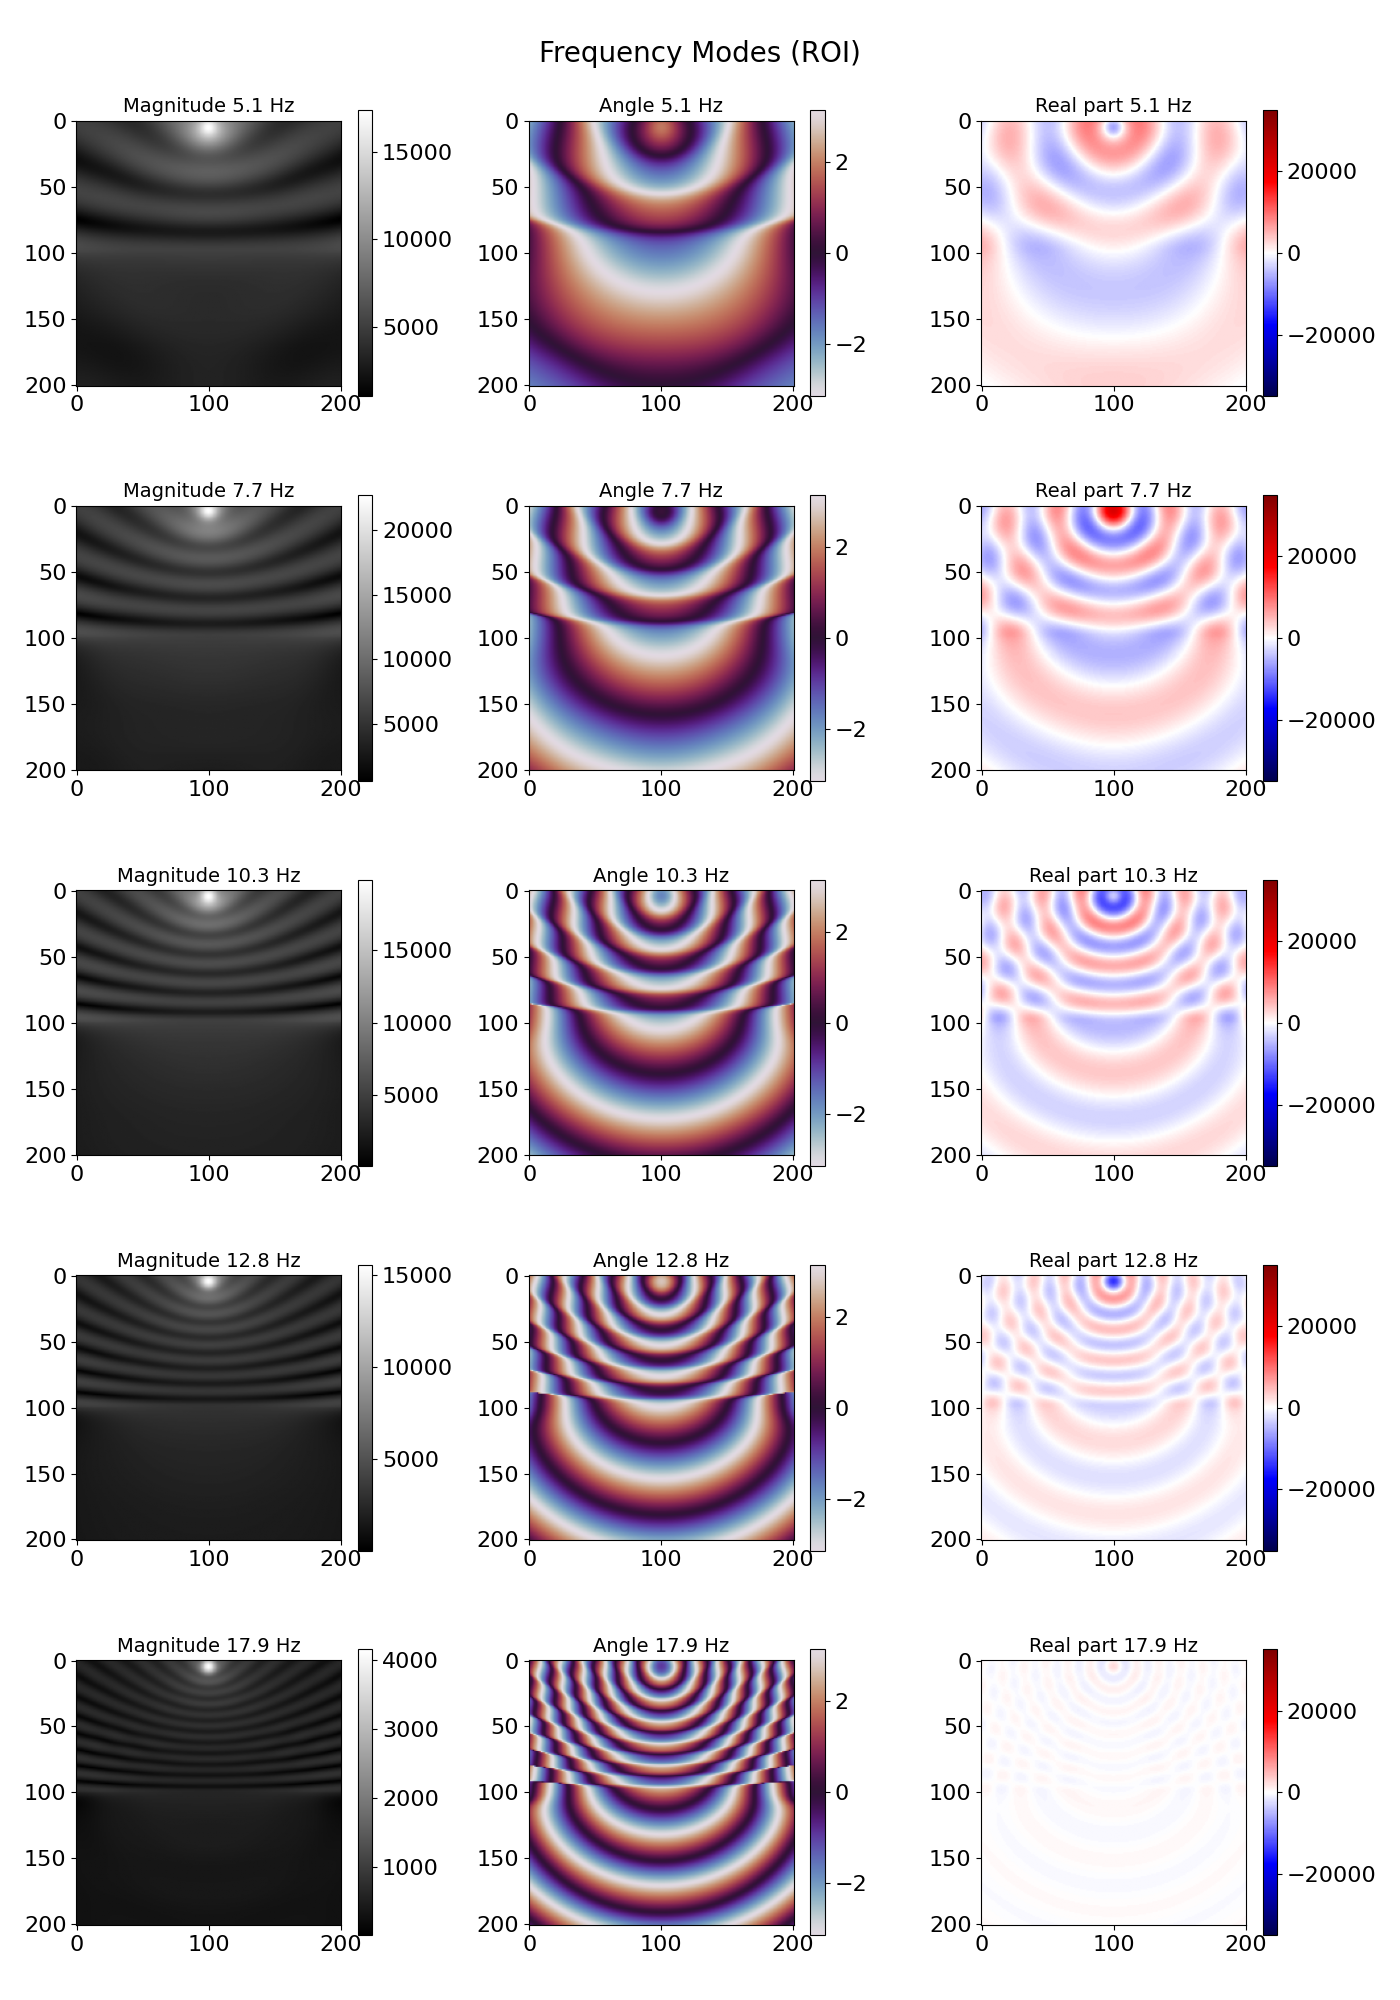

In [12]:
plt.figure(figsize=(14, 20))
plt.suptitle('Frequency Modes (ROI)', fontsize=20)
#frequencies_to_plot = np.linspace(0, nfreq-1, num=5, dtype=int)
frequencies_to_plot = [10, 15, 20, 25, 35]
for i, freq in enumerate(frequencies_to_plot):
    plt.subplot(5, 3, 3*i+1)
    im1 = plt.imshow(np.abs(freq_modes.data[freq].T[idx_domain_ROI[1:]]), cmap='gray')
    plt.title(f'Magnitude {1e3*frequencies.data[freq]:.1f} Hz', fontsize=14)
    plt.colorbar(im1, shrink=0.9)

    plt.subplot(5, 3, 3*i+2)
    im2 = plt.imshow(np.angle(freq_modes.data[freq].T[idx_domain_ROI[1:]]), cmap='twilight', vmin=-np.pi, vmax=np.pi)
    plt.title(f'Angle {1e3*frequencies.data[freq]:.1f} Hz', fontsize=14)
    plt.colorbar(im2, shrink=0.9)

    plt.subplot(5, 3, 3*i+3)
    im3 = plt.imshow(np.real(freq_modes.data[freq].T[idx_domain_ROI[1:]]), cmap='seismic', vmin=-3.5e4, vmax=3.5e4)
    plt.title(f'Real part {1e3*frequencies.data[freq]:.1f} Hz', fontsize=14)
    plt.colorbar(im3, shrink=0.9)

plt.tight_layout()
plt.show()

#### 4. Source Spatial Analysis

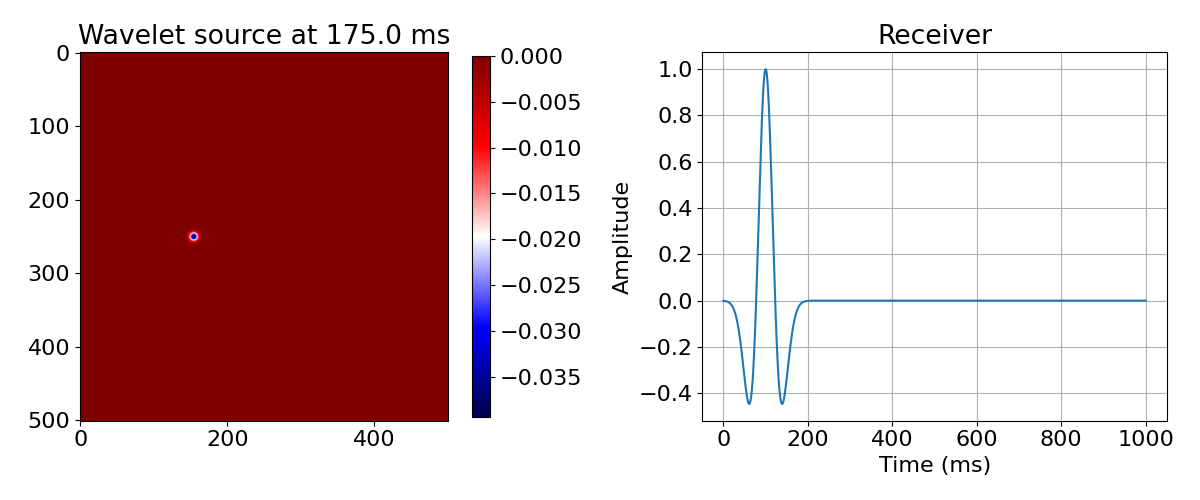

In [47]:
source = np.einsum('i,jk->ijk', np.squeeze(geometry.src.data), src_space.data)

time_instant = 200
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
im1 = plt.imshow(source[time_instant], cmap='seismic')
plt.colorbar(im1, shrink=0.98)
plt.title(f'Wavelet source at {geometry.time_axis.time_values[time_instant]:.1f} ms')


plt.subplot(1, 2, 2)
plt.plot(geometry.time_axis.time_values, source[:, 250, 154])
plt.title('Receiver')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()
plt.show()


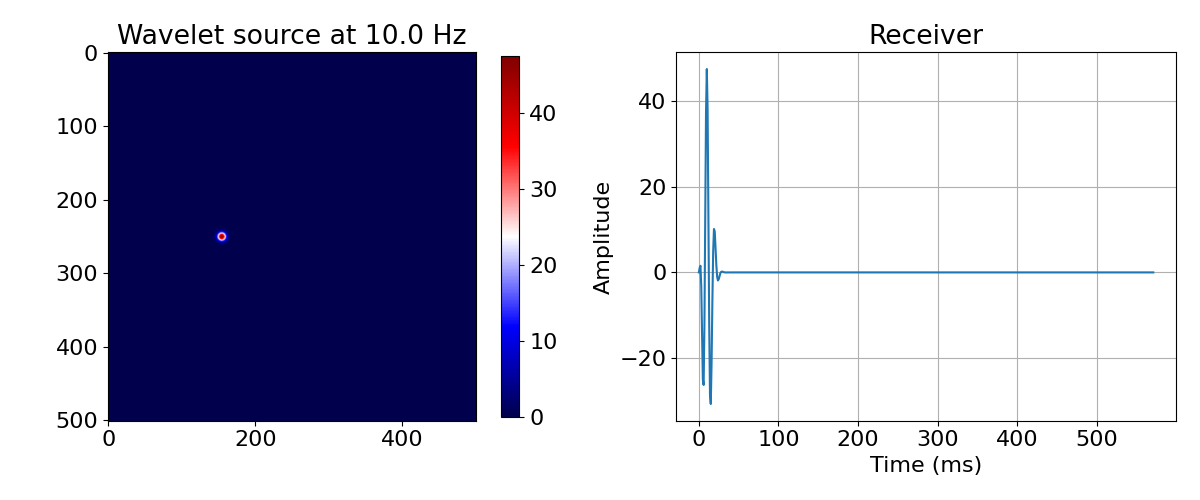

In [75]:
source_FFT_space_real = np.einsum('i,jk->ijk', np.squeeze(np.real(source_FFT_real)), src_space.data)

this_nfrequency = 10
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
im1 = plt.imshow(source_FFT_space_real[this_nfrequency], cmap='seismic')
plt.colorbar(im1, shrink=0.98)
plt.title(f'Wavelet source at {1000*source_freq_vector_real[this_nfrequency]:.1f} Hz')


plt.subplot(1, 2, 2)
plt.plot(source_freq_vector_real*1000, source_FFT_space_real[:, 250, 154])
plt.title('Receiver')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()
plt.show()

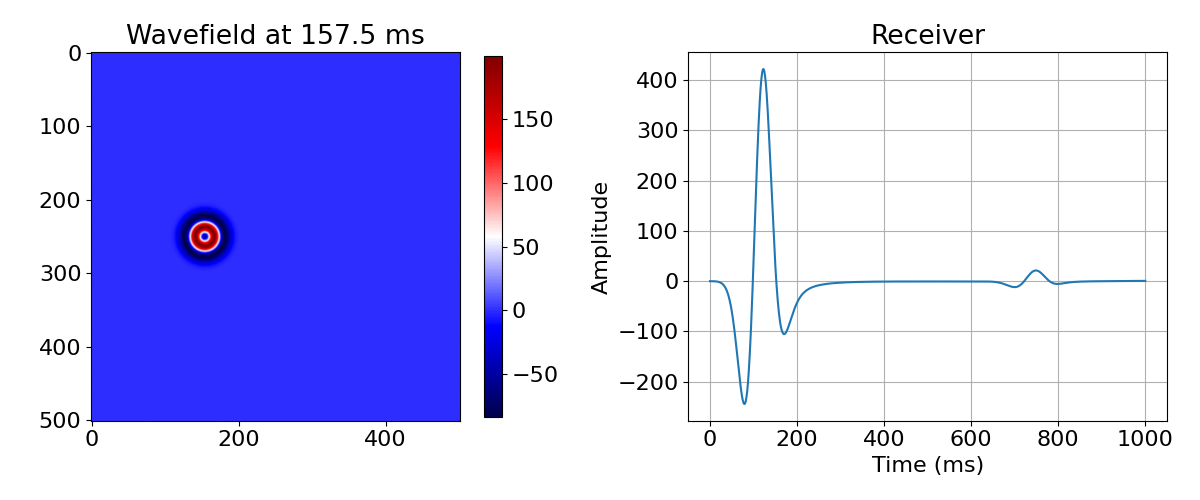

In [77]:
time_instant = 180

domain_size = 1.e-3 * np.array(model.domain_size)
extent = [model.origin[0], model.origin[0] + domain_size[0],
    model.origin[1] + domain_size[1], model.origin[1]]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
im1 = plt.imshow(u.data[time_instant], cmap='seismic')
plt.colorbar(im1, shrink=0.98)
plt.title(f'Wavefield at {geometry.time_axis.time_values[time_instant]:.1f} ms')

plt.subplot(1, 2, 2)
plt.plot(geometry.time_axis.time_values, u.data[:, 250, 154])
plt.title('Receiver')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()
plt.show()

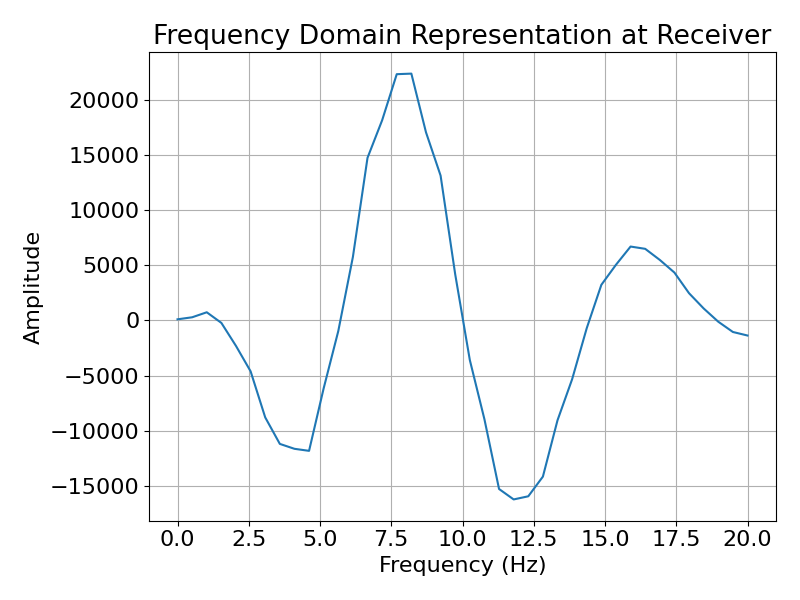

In [14]:
plt.figure()
plt.plot(frequencies.data[:]*1000, np.real(freq_modes.data[:, 250, 154]))
plt.title('Frequency Domain Representation at Receiver')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()
plt.show()

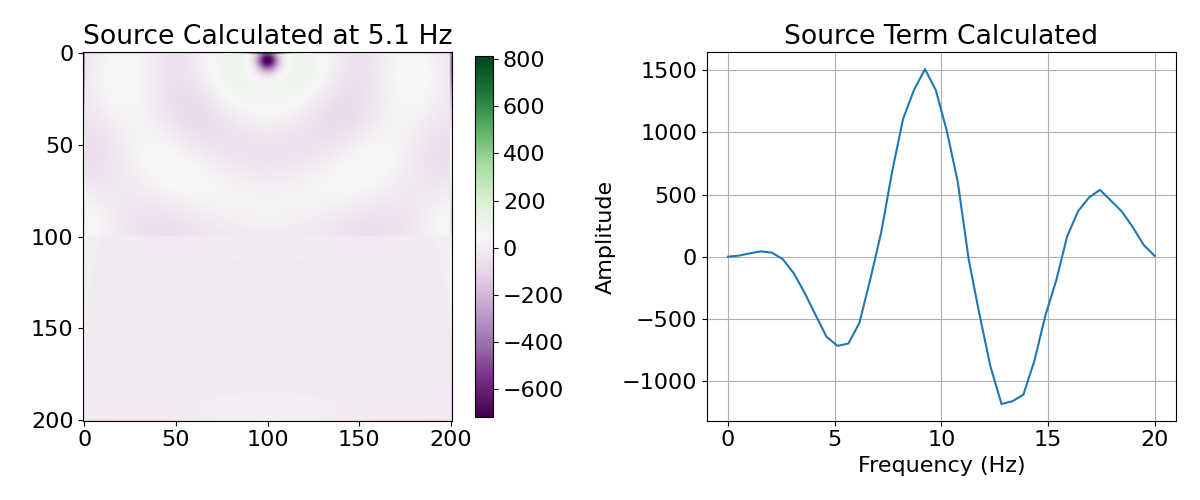

In [15]:
this_nfrequency = 10
laplace = sp.ndimage.laplace(np.real(freq_modes.data)[idx_domain_ROI], axes=(1,2))

second_term = np.einsum('i,ijk->ijk', (2*np.pi*frequencies.data)**2,
                        np.einsum('ij,kij->kij', (1/model.vp.data[idx_domain_ROI[1:]])**2, np.real(freq_modes.data)[idx_domain_ROI]))

source_term_calculated = -laplace - second_term

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
im1 = plt.imshow(source_term_calculated[this_nfrequency, :, :].T, cmap='PRGn')
plt.colorbar(im1, shrink=0.98)
plt.title(f'Source Calculated at {1e3*frequencies.data[this_nfrequency]:.1f} Hz')


plt.subplot(1, 2, 2)
plt.plot(frequencies.data*1e3, source_term_calculated[:, 100, 4])
plt.title('Source Term Calculated')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()
plt.show()

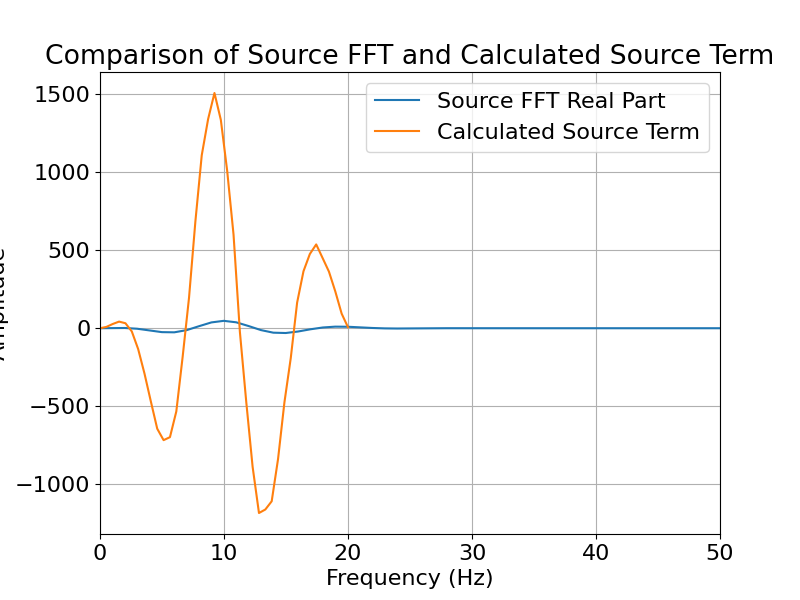

In [49]:
plt.figure()
plt.plot(source_freq_vector_real*1000, np.real(source_FFT_real), label='Source FFT Real Part')
plt.plot(frequencies.data*1e3, source_term_calculated[:, 100, 4], label='Calculated Source Term')
plt.title('Comparison of Source FFT and Calculated Source Term')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim(0, 50)
plt.legend()
plt.show()